In [1]:
from imports import *

In [4]:
from data_exploration import *

In [38]:
from math import log

In [47]:
from scipy.ndimage import gaussian_filter1d

In [2]:
data_path = 'C:\\Users\\homol\\Documents\\diplomamunka\\adat\\tweets_2015_2020'

In [5]:
tweet_df_list = []
stock_df_list = []
symbol_list = ['TSLA','AAPL','GOOG','GOOGL','AMZN','MSFT']
for symbol in symbol_list:
    tweet_df, stock_df = load(data_path,symbol)
    tweet_df_list.append(tweet_df)
    stock_df_list.append(stock_df)

In [6]:
def logreturn(stock_df):
    stock_df = stock_df.rename(columns={"day_date": "date"})
    ordered_df = stock_df.sort_values('date')
    ordered_df['close_value'] = ordered_df['close_value'].apply(lambda x:np.log(x))
    diff_df = ordered_df[['close_value']].diff()
    stock_df['logreturn'] = diff_df['close_value']
    return stock_df

In [7]:
logreturn_df_list = []
for stock_df in stock_df_list:
    logreturn_df = logreturn(stock_df)
    logreturn_df_list.append(logreturn_df)

In [14]:
def get_confident_df(tweet_df):
    # reducing the dataframe only the neccessary cols
    max_value_df = tweet_df[['date','neutral','positive','negative']]
    # choosing the max value of the row 
    max_value_df['max_value'] = max_value_df[['neutral','positive','negative']].max(axis=1) 

    # the sentiment score is at least 0.8 
    confident_df = max_value_df.loc[max_value_df['max_value']>=0.8].reset_index(drop=True)
    #unconfident_df = max_value_df.loc[max_value_df['max_value'] < 0.8].reset_index(drop=True)

    # choosing the max value label
    confident_df['max_value_label'] = confident_df[['neutral','positive','negative']].idxmax(axis=1)
    #unconfident_df['max_value_label'] = unconfident_df[['neutral','positive','negative']].idxmax(axis=1)
    conf_df = confident_df.loc[(confident_df['date']>=datetime.date(2016,1,1)) &
                           (confident_df['date']<=datetime.date(2019,12,31))]
    return conf_df

In [15]:
confident_df_list = []
for tweet_df in tweet_df_list:
    confident_df = get_confident_df(tweet_df)
    confident_df_list.append(confident_df)

C:\Users\homol\AppData\Local\Temp/ipykernel_36120/3353066896.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_value_df['max_value'] = max_value_df[['neutral','positive','negative']].max(axis=1)


In [16]:
def get_tweet_volume_df(conf_df):
    tweet_volume_df = conf_df.groupby('date').count().reset_index(drop=False)
    tweet_volume_df['tweet_volume'] = tweet_volume_df['neutral']
    tweet_volume_df = tweet_volume_df[['date','tweet_volume']]
    return tweet_volume_df

In [17]:
tweet_volume_df_list = []
for conf_df in confident_df_list:
    tweet_volume_df = get_tweet_volume_df(conf_df)
    tweet_volume_df_list.append(tweet_volume_df)

In [26]:
def get_ratio_df(conf_df):
    # conf:given_day_pos/given_day_all
    date_list = conf_df['date'].unique()
    pos_ratio_dict = {}
    neg_ratio_dict = {}
    for date in date_list:
        day_df = conf_df.loc[conf_df['date'] == date].reset_index(drop=True) 
        all_label = len(day_df)
        pos_label = len(day_df.loc[day_df['max_value_label'] == 'positive'].reset_index(drop=True))
        neg_label = len(day_df.loc[day_df['max_value_label'] == 'negative'].reset_index(drop=True))
        pos_ratio_dict[date] = pos_label/all_label
        neg_ratio_dict[date] = neg_label/all_label
        
    pos_ratio_df = pd.DataFrame(pos_ratio_dict.items(), columns=['date', 'pos_ratio'])
    neg_ratio_df = pd.DataFrame(neg_ratio_dict.items(), columns=['date', 'neg_ratio'])
    return pos_ratio_df, neg_ratio_df

In [28]:
def merge_ratio_df(pos_df,neg_df):
    sent_df = pd.merge(pos_df, neg_df,on='date')
    return sent_df

In [30]:
sent_df_list = []
for conf_df in confident_df_list:
    pos_ratio_df, neg_ratio_df = get_ratio_df(conf_df)
    sent_df = merge_ratio_df(pos_ratio_df,neg_ratio_df)
    sent_df_list.append(sent_df)

In [31]:
def merge_sent_logreturn(sent_df,logreturn_df):
    logreturn_sent_df = pd.merge(logreturn_df,sent_df,on='date')
    return logreturn_sent_df

In [39]:
def rescaling(series):
    new_value_list = []
    NewMax = 0.3
    NewMin = 0
    OldMax = series.max()
    OldMin = series.min()
    for value in series:
        OldRange = (OldMax - OldMin)  
        NewRange = (NewMax - NewMin)  
        NewValue = (((value - OldMin) * NewRange) / OldRange) + NewMin
        new_value_list.append(NewValue)
    return new_value_list

In [36]:
final_df_list = []
for i,sent_df in enumerate(sent_df_list):
    logreturn_sent_df = merge_sent_logreturn(sent_df,logreturn_df_list[i])
    final_df = pd.merge(logreturn_sent_df[['date','logreturn','pos_ratio','neg_ratio']],
                        tweet_volume_df_list[i], on='date').sort_values('logreturn',ascending=False).reset_index(drop=True)
    final_df_list.append(final_df)

In [42]:
scaled_volume_lst_list = []
for final_df in final_df_list:
    scaled_volume_list = rescaling(final_df['tweet_volume'])
    scaled_volume_lst_list.append(scaled_volume_list)

In [44]:
str_date_lst_list = []
for final_df in final_df_list:
    str_date_list = [ day.strftime('%m/%d/%Y')for day in final_df['date']]
    str_date_lst_list.append(str_date_list)


In [118]:
fontdict = {'fontsize':15,'fontweight' : 'bold'}

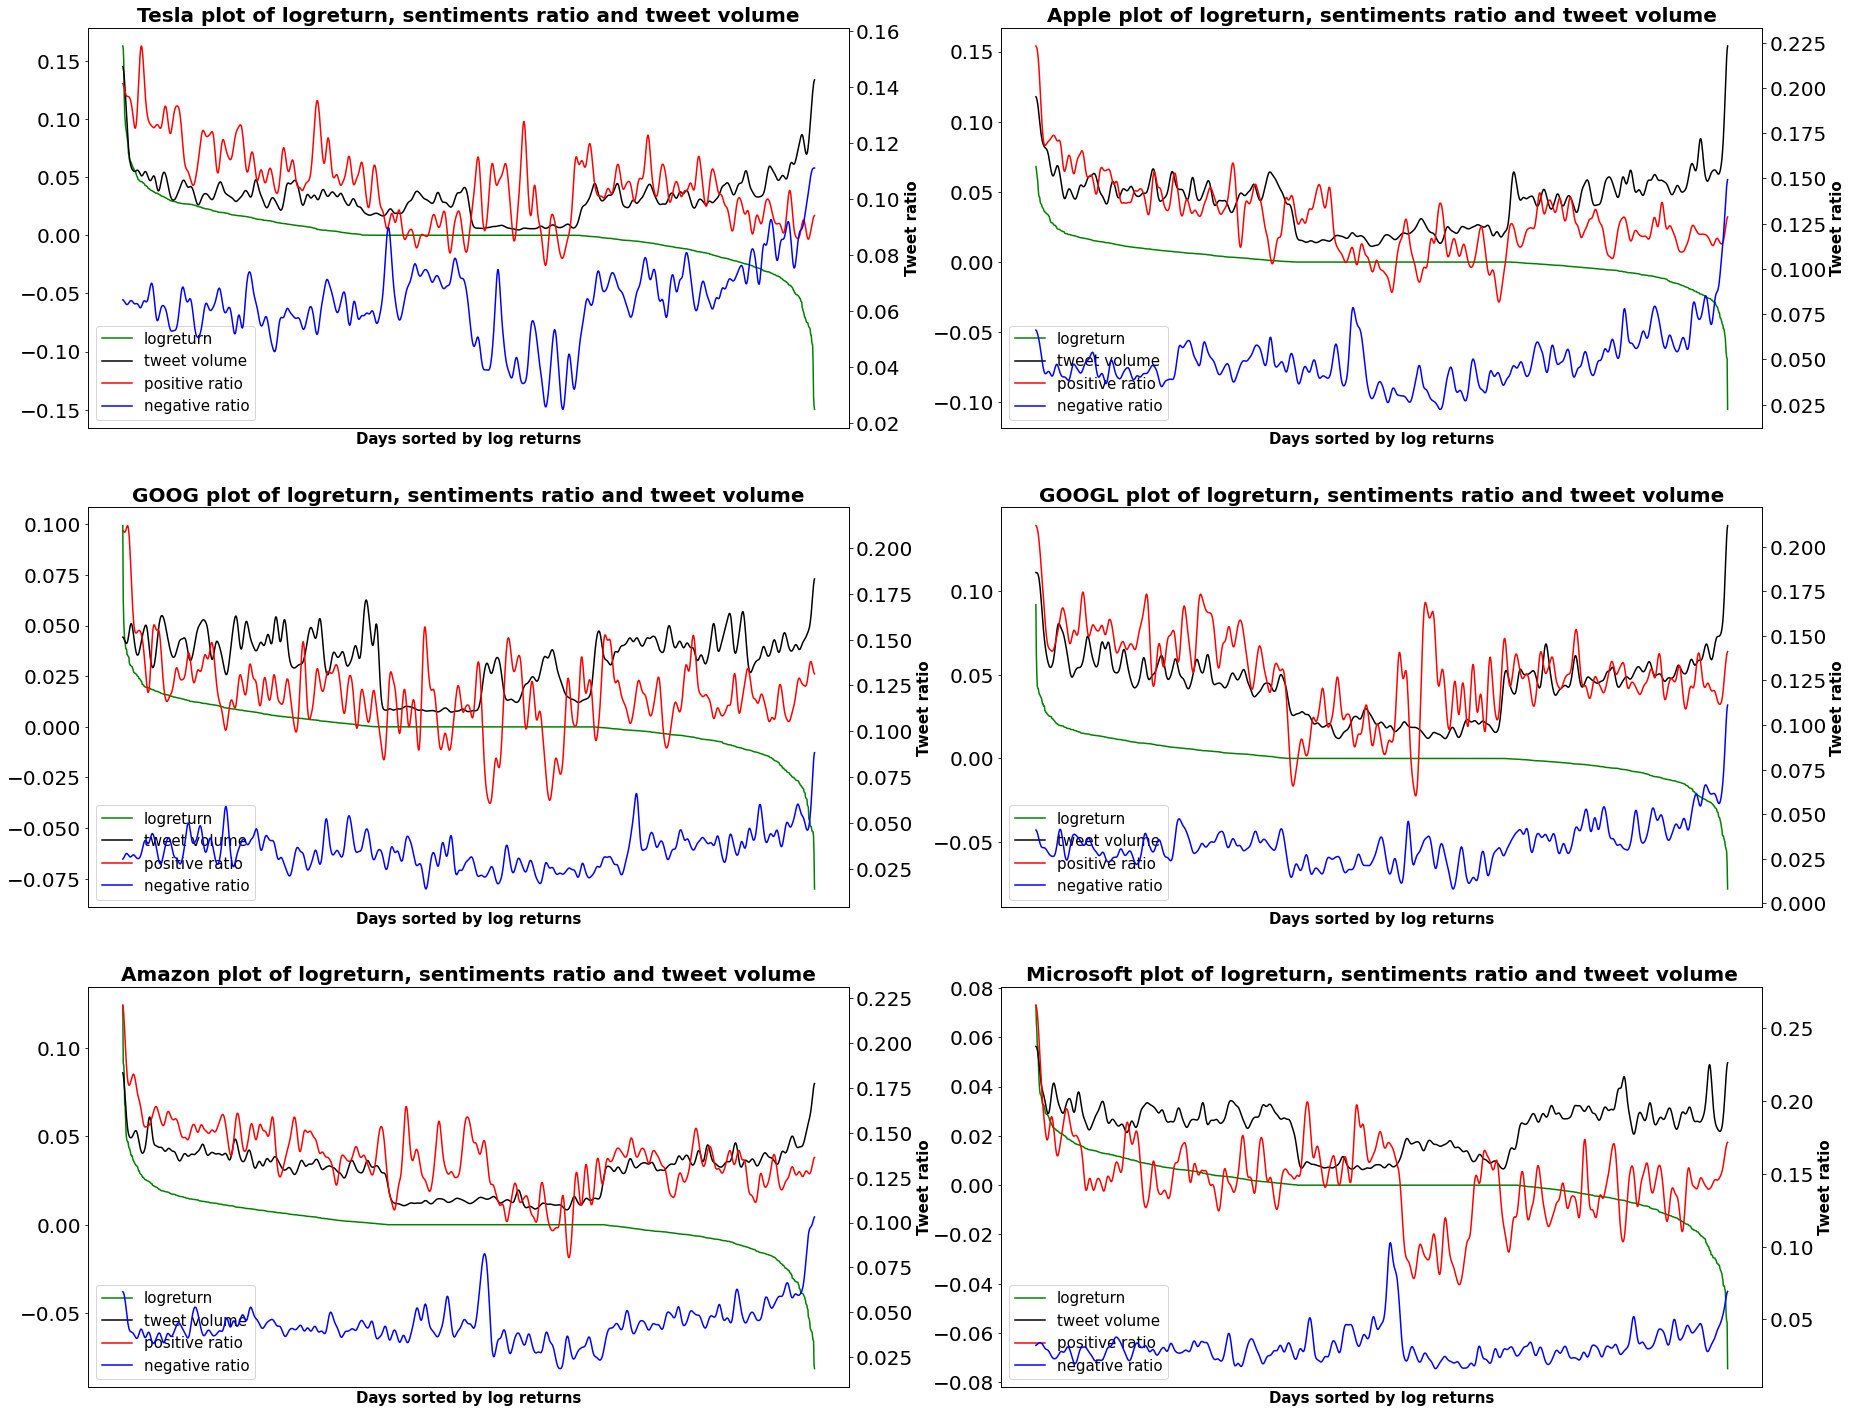

In [122]:
company_name_list = ['Tesla', 'Apple', 'GOOG', 'GOOGL', 'Amazon', 'Microsoft']

fig, axes = plt.subplots(3,2,figsize=(30,25))
axes_list = axes.flatten() #sublots axes

for i,ax in enumerate(axes_list):
    ax.set_title(f'{company_name_list[i]} plot of logreturn, sentiments ratio and tweet volume',fontdict=fontdict)
    c1, = ax.plot(str_date_lst_list[i],final_df_list[i]['logreturn'],color='green')
    c2, = ax.plot(str_date_lst_list[i],gaussian_filter1d(scaled_volume_lst_list[i], sigma=5),color="black")

    axes2 = ax.twinx()
    c3, = axes2.plot(str_date_lst_list[i],gaussian_filter1d(final_df_list[i]['pos_ratio'], sigma=5),color="red",)
    c4, = axes2.plot(str_date_lst_list[i],gaussian_filter1d(final_df_list[i]['neg_ratio'], sigma=5),color="blue")

    axes2.set_ylabel('Tweet ratio',fontsize=15, fontweight='bold')

    ax.legend([c1, c2, c3, c4],['logreturn', 'tweet volume','positive ratio', 'negative ratio'],fontsize=15)
    ax.set_xlabel('Days sorted by log returns',fontsize=15, fontweight='bold')
    ax.set_xticks([])
    
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    axes2.xaxis.set_tick_params(labelsize=20)
    axes2.yaxis.set_tick_params(labelsize=20)
    
plt.savefig(r'C:\Users\homol\Desktop\stock_subplots.png')